## Use Analysis Tools to design a Threshold Region for Orange Balls

In [42]:
import os, sys, copy, random, pickle
sys.path.append("../")
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from modules.Interproc import DBInterface
from modules.Interproc import GuiviewState
from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.imgutils import (filter_pixels_circle, crop_img)

from modules.AnalysisHelpers import ( multiPlot, colorCube,
         SubprocColorCube, subprocColorCube, buildConfusionData, 
         buildConfusionPlotData, buildRegionMarkers, confusionPlotByViews,
         confusionPlotByImage, PixelConfusionMatrix, cvtPlot,
         applyTracker, presetCubeViews, bytesToPic,
         croppedPic, bytesToPic2, colorInRange)

from skimage.filters import sobel, gaussian, scharr, threshold_adaptive

from modules.IterThresh import iterThreshA
from modules.AnalysisHelpers import imgToColors, pointsToList
from modules.EvalHelpers import EvalTracker

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#load in data
DATA_DIR = "../data/misc/books/iterthresha-vizdebug-1/"

db_name = "interprocGreen.db"
gsDb = DBInterface(os.path.join(DATA_DIR, db_name))
listGSg = [ pickle.loads(d[1]) for d in gsDb.selectAll()]

db_name = "interprocOrange.db"
gsDb = DBInterface(os.path.join(DATA_DIR, db_name))
listGSo = [ pickle.loads(d[1]) for d in gsDb.selectAll()]

print [_gs.frameCounter for _gs in listGSg]
print [_gs.frameCounter for _gs in listGSo]

col1, col2, col3, col4 = [], [], [], []

for _gs in listGSo:
    _gs.initDisplay()
    col1.append(_gs.getOrigFrame())
    col2.append(_gs.display.scoreFrame.copy())
    
for _gs in listGSg:
    _gs.initDisplay()
    col3.append(_gs.getOrigFrame())
    col4.append(_gs.display.scoreFrame.copy())
    
chart_data = [col1, col2, col3, col4]

[0, 22, 40, 47, 49, 78, 84, 125, 188, 380]
[0, 9, 78, 116, 136, 176, 195, 246, 307, 340]


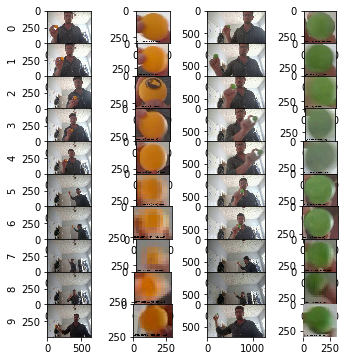

In [3]:
#concise view
multiPlot(chart_data, hspace = 0, wspace = 0, figsize = (6,6), input_transform_titles = range(len(chart_data[0])),
         bGrid=True)

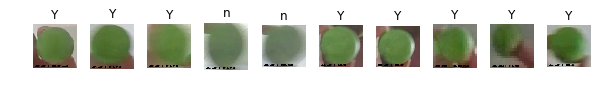

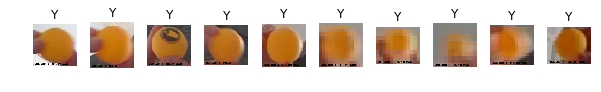

In [58]:
#View which frames of each video have successful Tracks

    #note: orange does not have a known region yet so all tracks will fail

ev = EvalTracker()
chart_legend = ["n", "Y"]

def showSuccess(_ballColor, _listGS, _listImgs):
    ''' display a plot of each scoreWindow and Y or n for trackSuccess'''

    tracker = TrackFactory(on=True)
    tracker.setInit(ballColor=_ballColor)
    tracker.setAlgoEnum(1)

    outputData = applyTracker(listGSg, tracker, bLogPlts=False)

    chart_col_title = [ chart_legend[int(ev.checkTrackSuccess(elem))] 
                          for elem in outputData['listScore']
                      ]
    chart_data = [[elem] for elem in _listImgs]

    multiPlot(chart_data
             ,input_frame_titles = chart_col_title
             ,bGrid = False
             ,bForceTitles = True
             )

showSuccess("green", copy.deepcopy(listGSg), copy.deepcopy(col4))
showSuccess("orange", copy.deepcopy(listGSo), copy.deepcopy(col2))

### Use Previous Style Analysis

In [5]:
# init params
tracker = TrackFactory(on=True)
tracker.setInit(ballColor="green")
tracker.setAlgoEnum(1)
thresh1 = (tracker.getTrackParams()['thresh_lo']
           ,tracker.getTrackParams()['thresh_hi'])
print thresh1

views1 = presetCubeViews()
view1 = views1[0][1]
print view1

((29, 86, 6), (64, 255, 255))
{'elevation': 95, 'azimuth': -81}


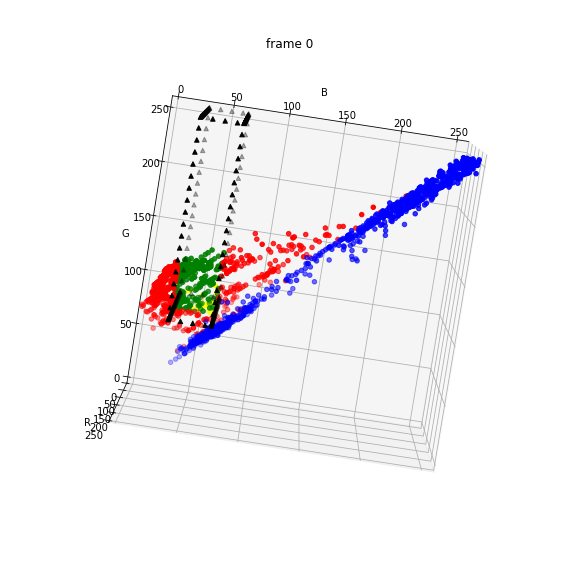

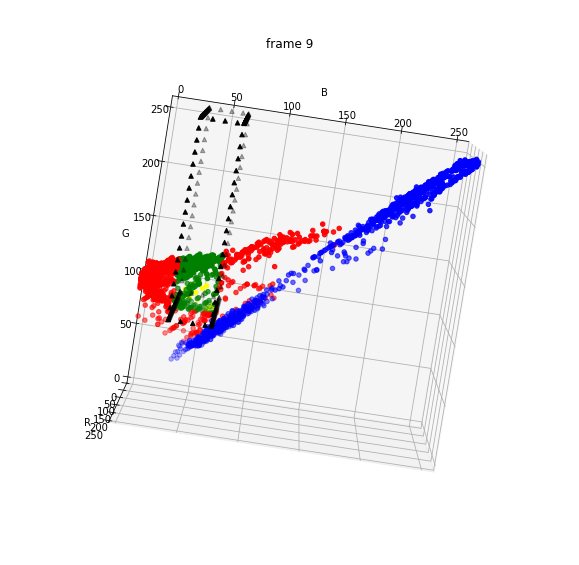

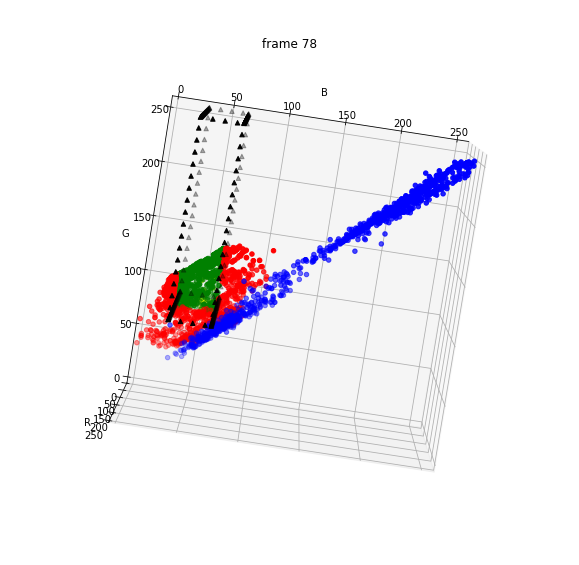

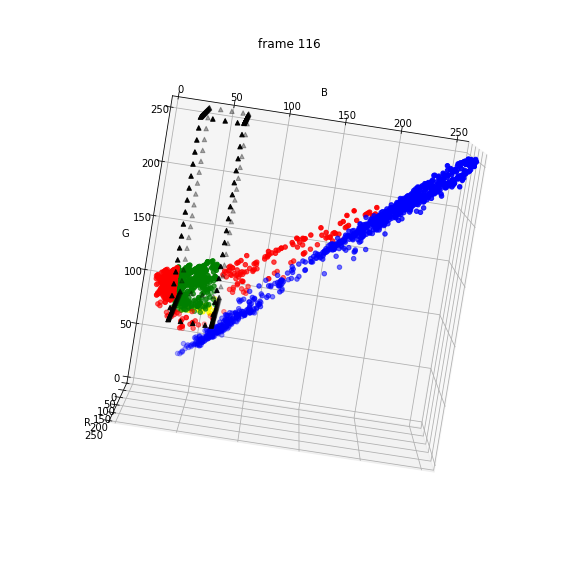

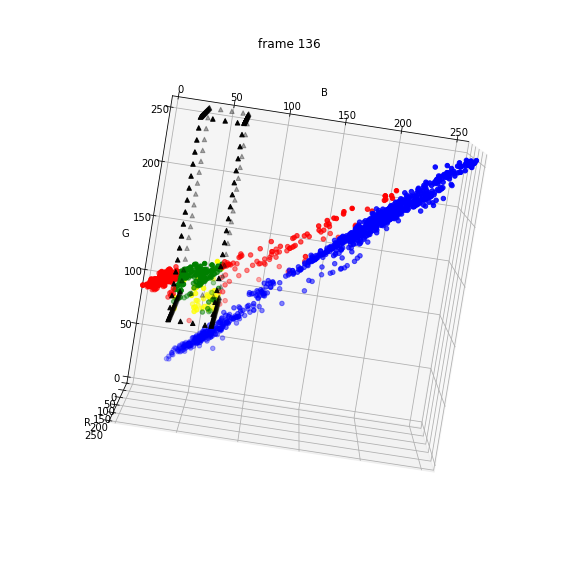

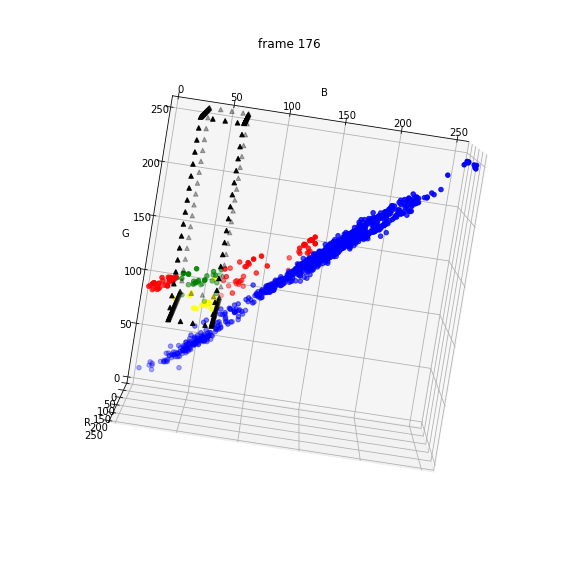

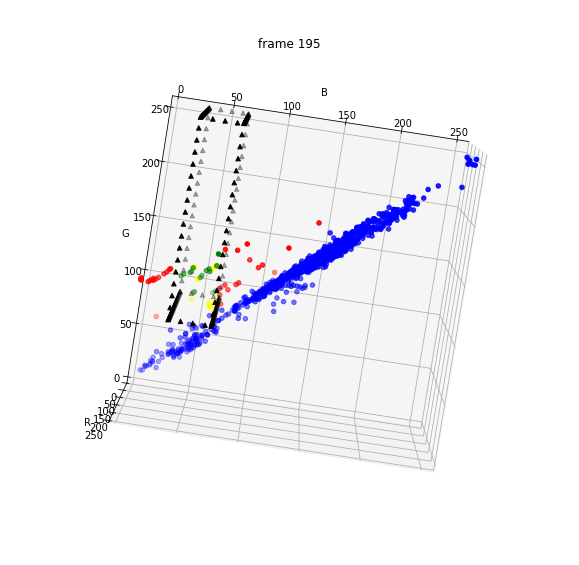

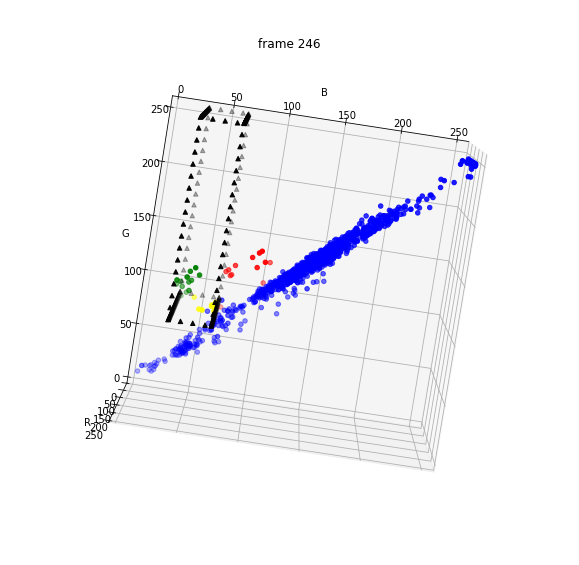

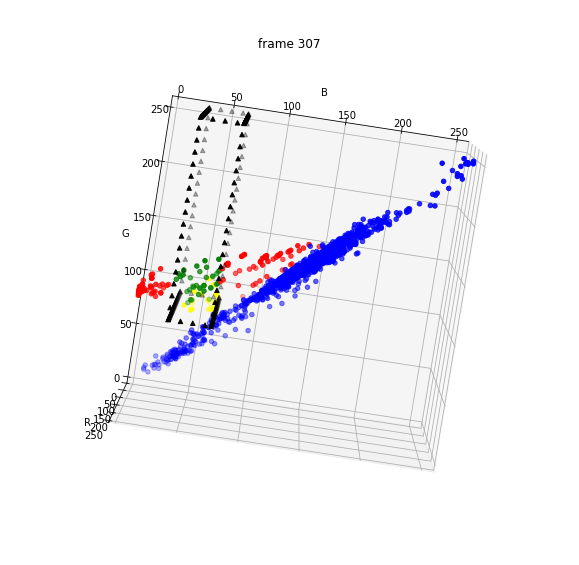

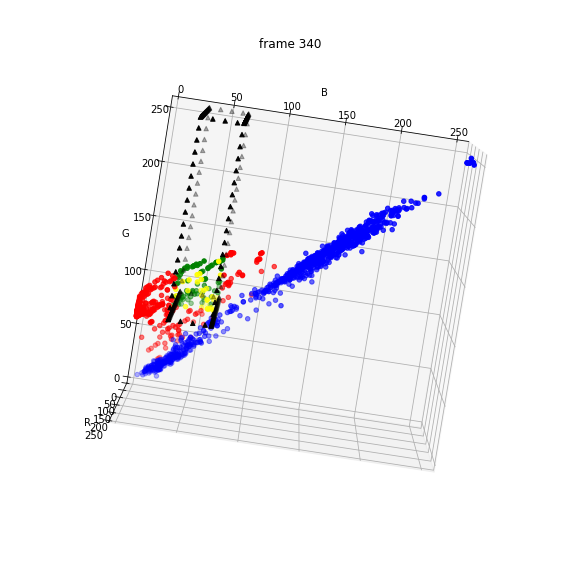

In [6]:
confusionPlotByImage( listGS = listGSo
                     ,inputThresh = thresh1
                     ,viewPositionDefined = view1
                     ,bOutputScore = False
                    )

In [7]:
#interactive:
_i = 3
inputThresh = thresh1
bOutputScore = False

_gs = listGSo[_i]

_pcm = buildConfusionData( _gs, [inputThresh]
                                        ,bOutputScore = bOutputScore)

_plotData = buildConfusionPlotData(_pcm)

_regionMarkers = buildRegionMarkers([inputThresh])

_title = 'frame ' + str(_gs.frameCounter)

subprocColorCube( confData = _plotData
          ,regionMarkers = _regionMarkers
#           ,title = _title
#           ,viewPositionDefined = viewPositionDefined
#           ,bInitPosition = True
#           ,figsize = figsize
         )

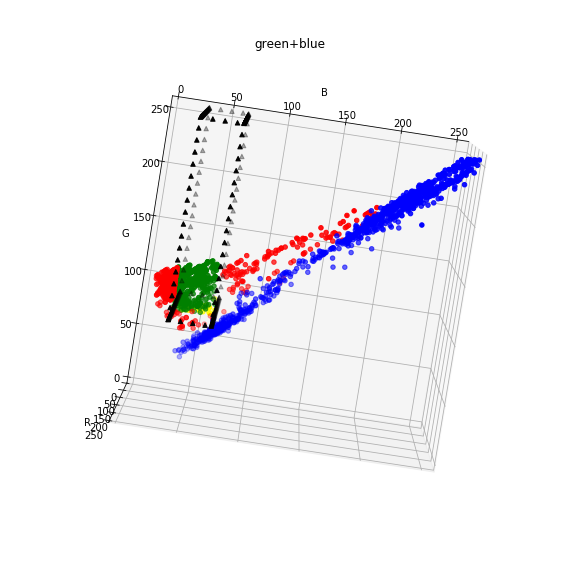

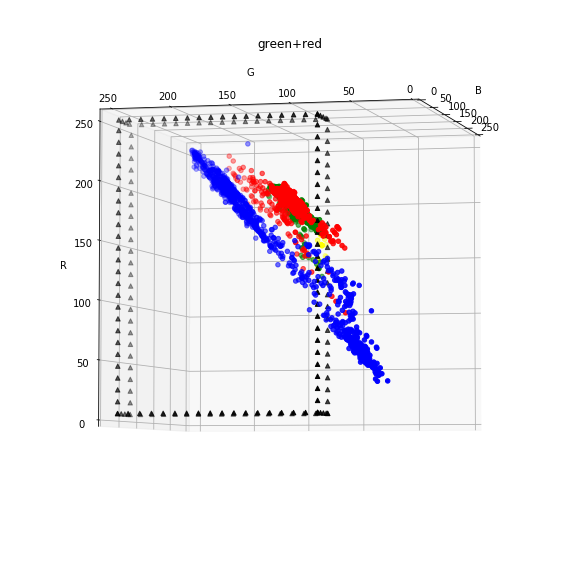

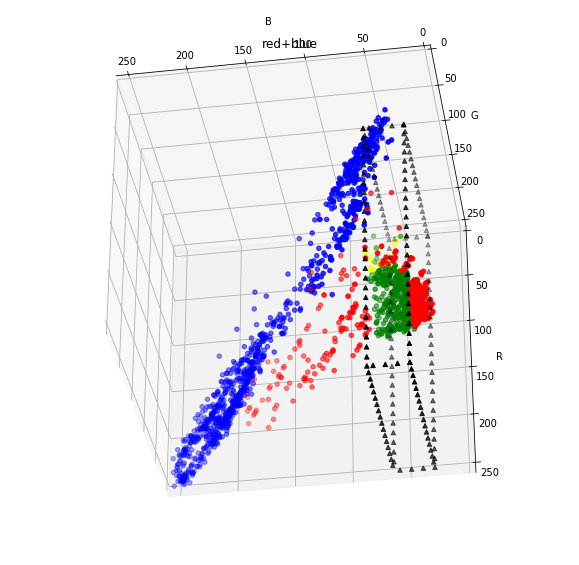

In [8]:
# 3 different of views

_pcm = buildConfusionData( _gs, [inputThresh]
                                        ,bOutputScore = bOutputScore)

_plotData = buildConfusionPlotData(_pcm)

confusionPlotByViews(_plotData, [thresh1])

### Use new style analysis

In [9]:
# build X, dataset of positive pixels from all frames in orange gs-list

X = np.empty(shape=(0,3), dtype='uint8')

#remove 3rd elemnt as it contains black labelling

frames = range(10)
frames.pop(2)

for i in frames:
    
    _gs = listGSo[i]

    pcm = PixelConfusionMatrix(img = _gs.getOrigFrame()
                              ,threshes = [thresh1]
                              ,circle = _gs.displayInputScore['0']['data']
                              )
    pcm.calc()

    pix1 = pcm.tpPix.copy()
    pix2 = pcm.fnPix.copy()
    
    X = np.concatenate((X,pix1, pix2))

In [10]:
from modules.AnalysisHelpers import channelsToColorStr

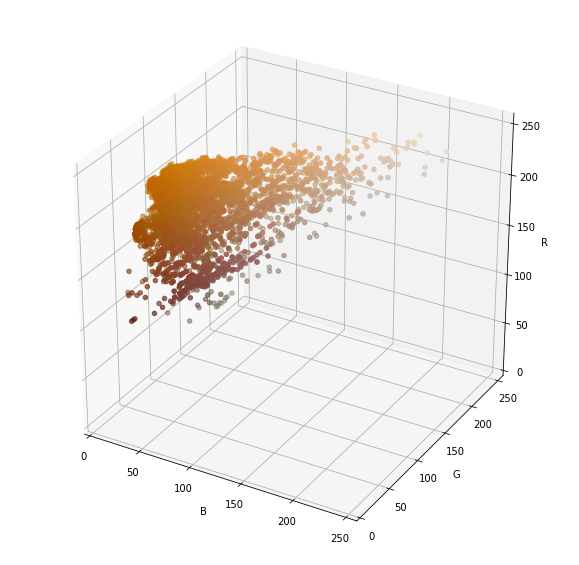

In [11]:
colorCube(X[:,0], X[:,1], X[:,2], listColors = channelsToColorStr(X[:,0], X[:,1], X[:,2]) )

In [12]:
#interactive 
subprocColorCube(X[:,0], X[:,1], X[:,2], listColors = channelsToColorStr(X[:,0], X[:,1], X[:,2]) )

loaded class type:  SubprocColorCube


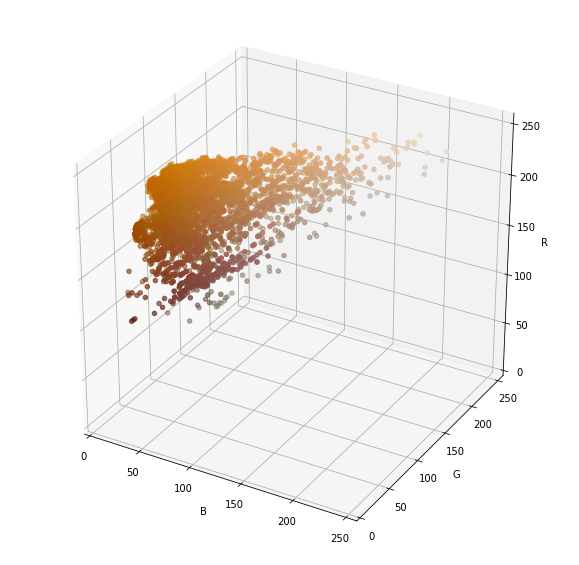

In [13]:
#loaded with a different view

p = SubprocColorCube()
p.load()
p.callPlot()

### Hand Build Regions

In [14]:
thresh1

((29, 86, 6), (64, 255, 255))

In [51]:
#Here's some hand built regions
    # note: they could be each 30 higher on min-red
    
thresh2 = ((6,30,90),(64,255,255))
thresh3 = ((64,100,110),(90,255,255))
thresh4 = ((90,120,130),(120,255,255))

In [55]:
threshes_1 = [thresh2]
threshes_2 = [thresh2, thresh3]
threshes_3 = [thresh2, thresh3, thresh4]

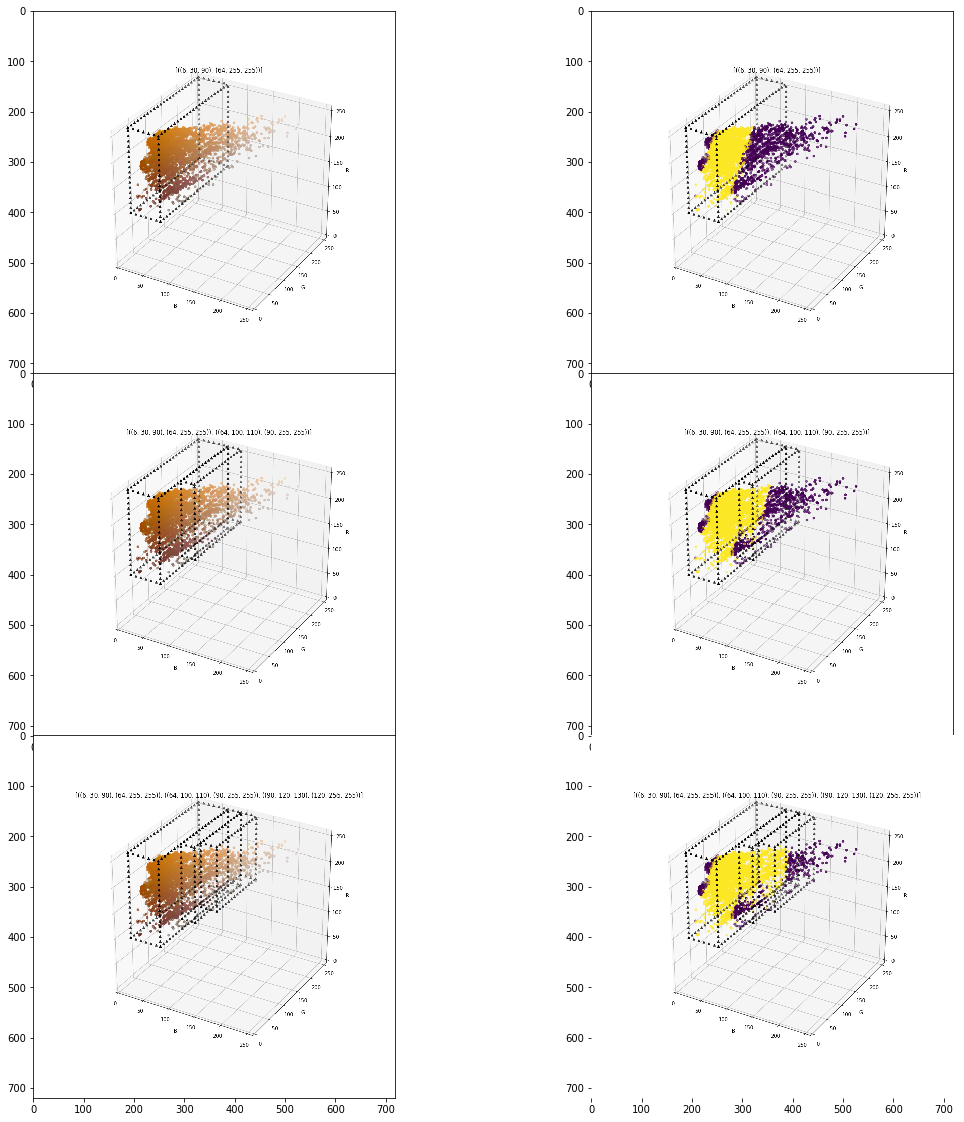

In [56]:
def orangeRegions(_threshes, realColors = True):
    
    if realColors:
        _tmpColors = channelsToColorStr(X[:,0], X[:,1], X[:,2]) 
    else:
        _tmpColors = colorInRange(X, _threshes)
    
    return bytesToPic(
        colorCube(X[:,0], X[:,1], X[:,2]
          ,listColors = _tmpColors
          ,regionMarkers = buildRegionMarkers(_threshes)
          ,title = str(_threshes)
          ,b_save = True
         )
    )

chart_data = [ 
     [orangeRegions(threshes_1), orangeRegions(threshes_2), orangeRegions(threshes_3)]
    ,[
       orangeRegions(threshes_1, realColors=False)
      ,orangeRegions(threshes_2, realColors=False)
      ,orangeRegions(threshes_3, realColors=False)
     ]
    ]

multiPlot(chart_data, figsize= (20,20), wspace=0, hspace=0, bGrid=True)

In [57]:
#interactive

_threshes = threshes_3
_tmpColors = colorInRange(X, _threshes)

subprocColorCube(X[:,0], X[:,1], X[:,2]
          ,listColors = _tmpColors
          ,regionMarkers = buildRegionMarkers(_threshes)
         )